In [4]:
!pip install pymupdf pillow transformers tqdm pandas pytesseract pillow easyocr langchain langchain-community langchain_openai faiss-cpu rank_bm25 pdf2image

In [5]:
import fitz
import io
from PIL import Image
import os
from pathlib import Path


In [7]:
import fitz  # PyMuPDF
from PIL import Image
import io, os

def extract_slides_fitz(pdf_path, output_dir, lower_crop_extra=200):
    os.makedirs(output_dir, exist_ok=True)
    pdf = fitz.open(pdf_path)
    print(f"[INFO] Loaded '{pdf_path}' with {len(pdf)} pages.")

    for i, page in enumerate(pdf, start=1):
        pix = page.get_pixmap(dpi=200)
        img = Image.open(io.BytesIO(pix.tobytes("png")))

        # Crop lower for slides 1–2
        if i in [1, 2]:
            w, h = img.size
            crop_box = (0, 0, w, min(h + lower_crop_extra, h))
            img = img.crop(crop_box)

        img.save(os.path.join(output_dir, f"slide_{i:02d}.png"), "PNG")

    print(f"Extracted {len(pdf)} slides from {pdf_path}")

# Q1 + Q2
extract_slides_fitz("2025q1-alphabet-earnings-slides.pdf", "slides_q1_2025")
extract_slides_fitz("2025q2-alphabet-earnings-slides.pdf", "slides_q2_2025")


[INFO] Loaded '2025q1-alphabet-earnings-slides.pdf' with 10 pages.
Extracted 10 slides from 2025q1-alphabet-earnings-slides.pdf
[INFO] Loaded '2025q2-alphabet-earnings-slides.pdf' with 10 pages.
Extracted 10 slides from 2025q2-alphabet-earnings-slides.pdf


In [10]:
import pytesseract
from PIL import Image
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

def ocr_folder(folder, label):
    docs = []
    for fname in sorted(os.listdir(folder)):
        if fname.endswith(".png"):
            path = os.path.join(folder, fname)
            text = pytesseract.image_to_string(Image.open(path))
            if text.strip():
                docs.append(Document(
                    page_content=text,
                    metadata={"image_path": path, "source_report": label}
                ))
    return docs

docs_q1 = ocr_folder("slides_q1_2025", "Q1_2025")
docs_q2 = ocr_folder("slides_q2_2025", "Q2_2025")
docs = docs_q1 + docs_q2
print(f"Loaded {len(docs)} caption documents.")

Loaded 20 caption documents.


In [11]:
from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.retrievers import BM25Retriever
import os

from dotenv import load_dotenv
load_dotenv()

embedding_model = OpenAIEmbeddings(
    model="text-embedding-3-small",
    api_key=os.getenv("OPENAI_API_KEY")
)

# Build indices
faiss_store = FAISS.from_documents(docs, embedding_model)
faiss_store.save_local("faiss_index")

bm25_retriever = BM25Retriever.from_documents(docs)
bm25_retriever.k = 10

print("Both FAISS and BM25 indices built and saved.")

c:\Users\Admin\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Both FAISS and BM25 indices built and saved.



--- Result 1 ---
Caption: Alphabet
Q@1 2025 Earnings

April 24, 2025



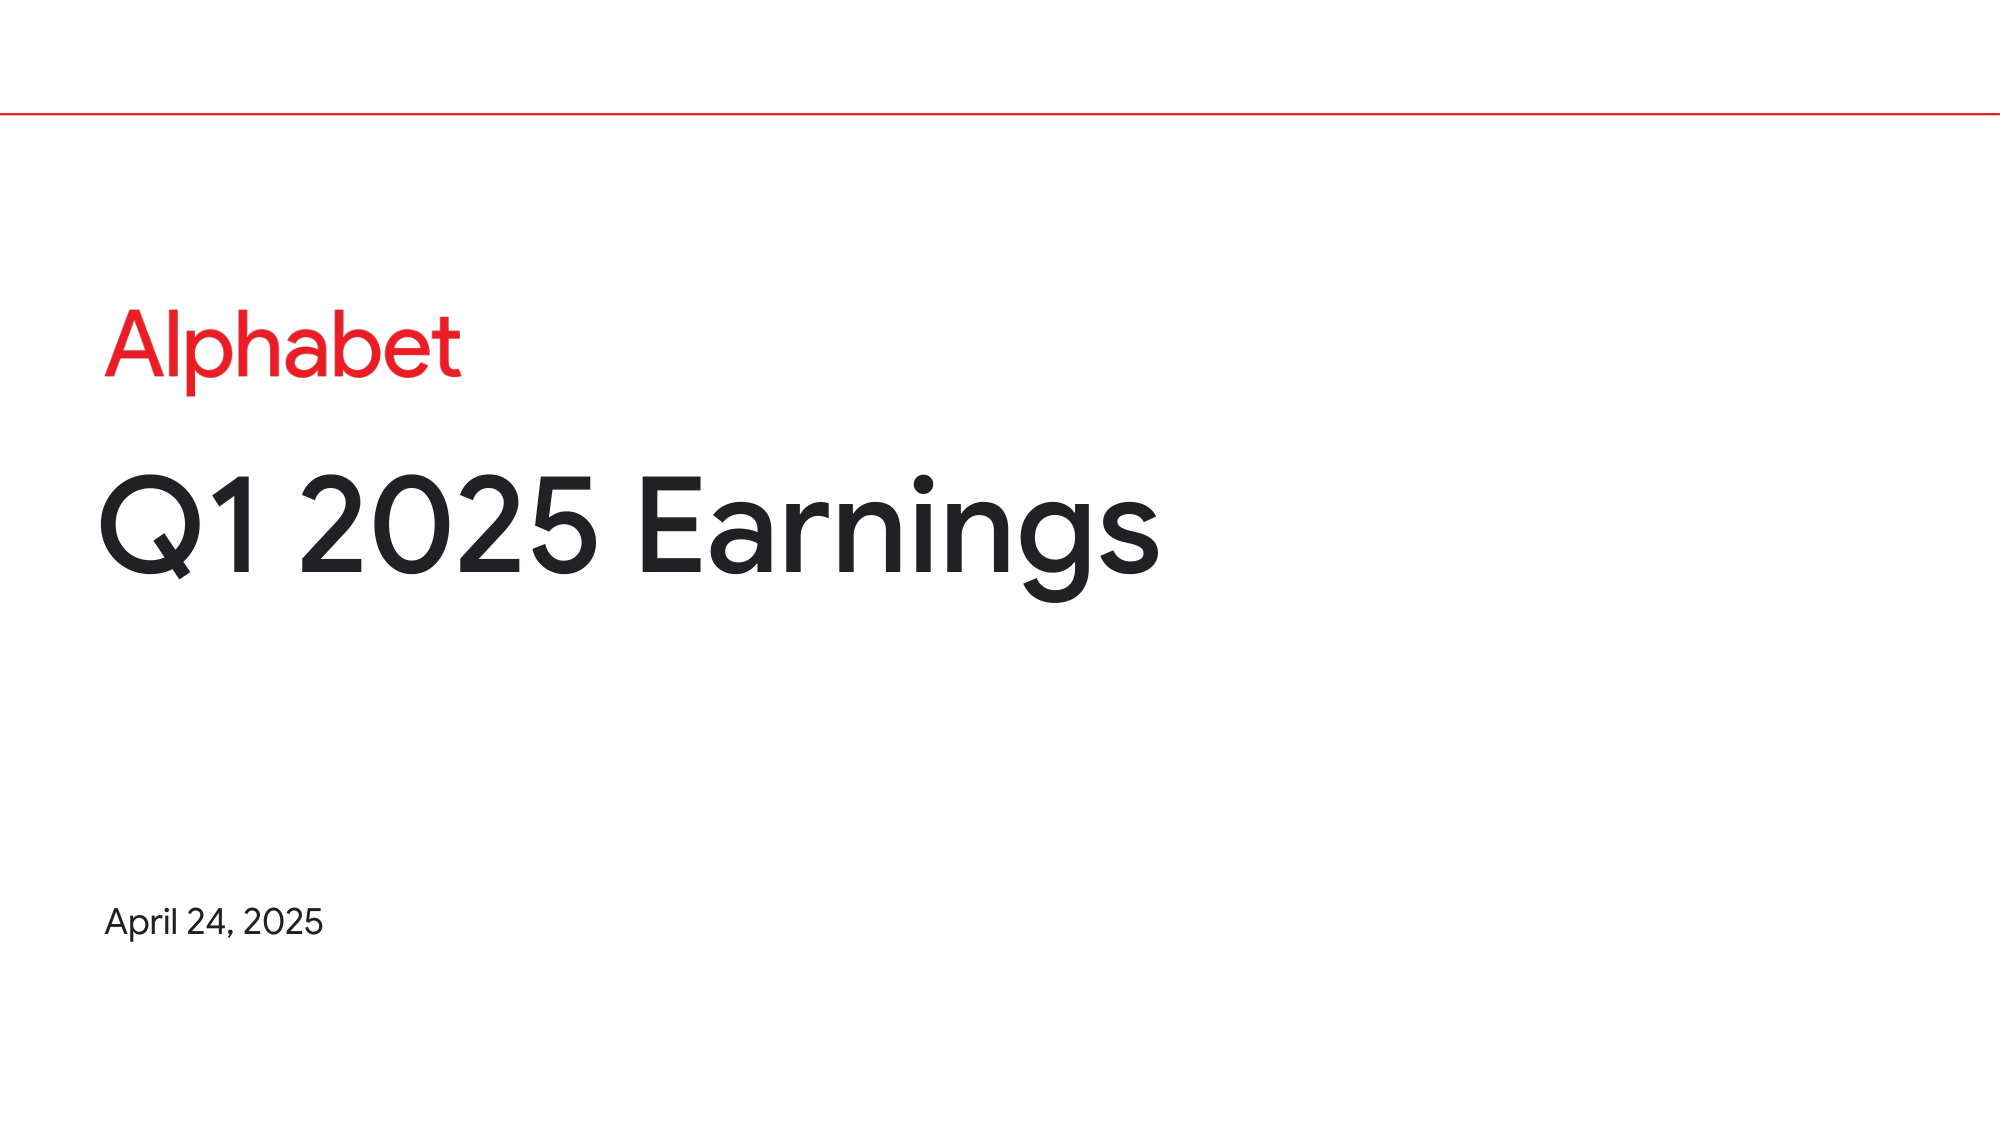


--- Result 2 ---
Caption: Alphabet
Q@2 2025 Earnings

July 23, 2025



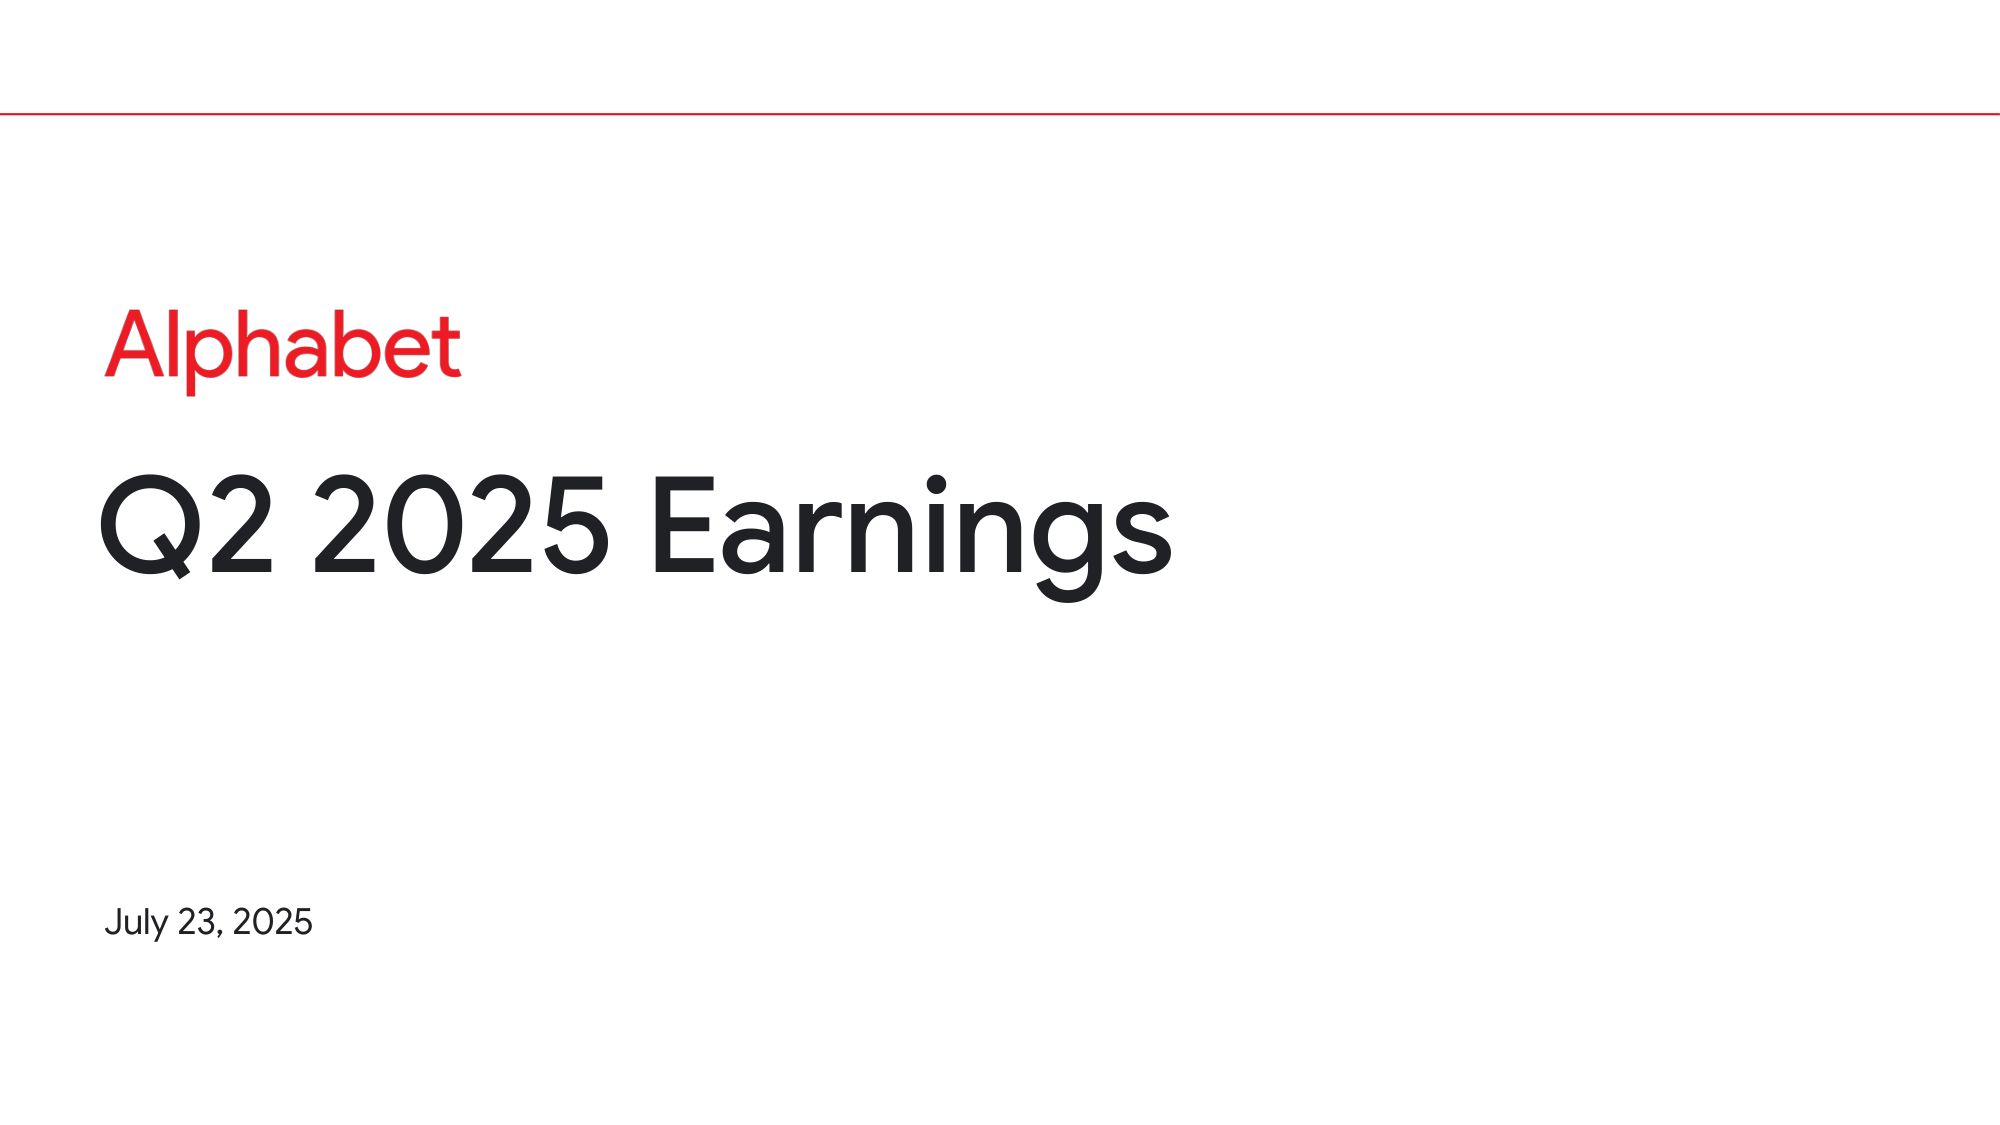


--- Result 3 ---
Caption: Q1 2025 Earnings

Alphabet

Note About Forward-Looking Statements and
Non-GAAP Financial Measures

This presentation may contain forward-looking statements regarding our business, operations, and
financial performance. Such statements are based on current expectations and assumptions that are
subject to a number of risks and uncertainties. Actual results could differ materially. Please refer to our
Forms 10-K and 10-Q, including the risk factors. We undertake no obligation to update any forward-looking
statement, except as required by law. Given these risk and uncertainties, investors are cautioned not to
place undue reliance on such forward-looking statements.

We present both GAAP and non-GAAP financial measures in this presentation. A reconciliation of
non-GAAP to GAAP measures is included in this presentation and in the most recent earnings press
release, which is distributed and available to the public through our Investor Relations website located at
ab

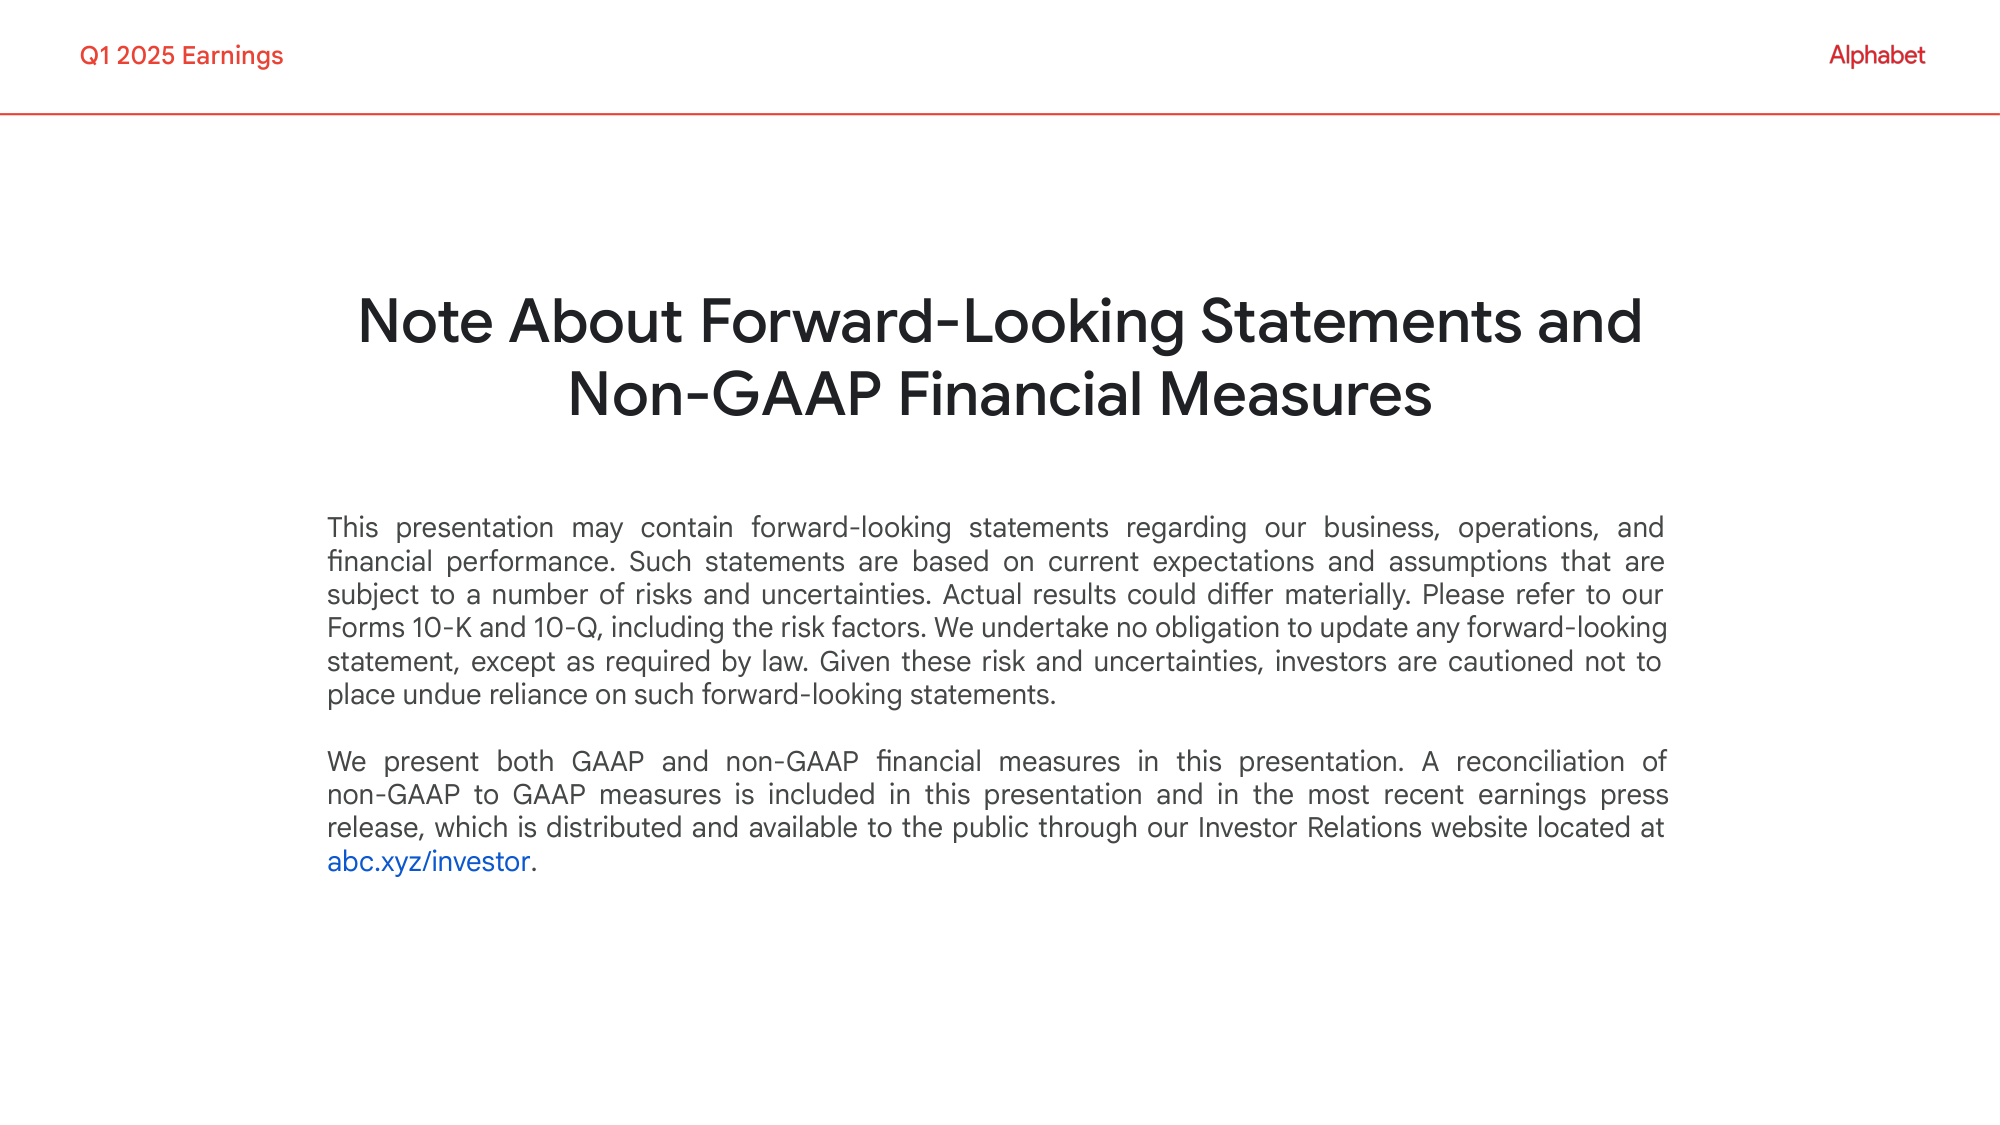


--- Result 4 ---
Caption: Q2 2025 Earnings

Alphabet

Note About Forward-Looking Statements and
Non-GAAP Financial Measures

This presentation may contain forward-looking statements regarding our business, operations, and
financial performance. Such statements are based on current expectations and assumptions that are
subject to a number of risks and uncertainties. Actual results could differ materially. Please refer to our
Forms 10-K and 10-Q, including the risk factors. We undertake no obligation to update any forward-looking
statement, except as required by law. Given these risk and uncertainties, investors are cautioned not to
place undue reliance on such forward-looking statements.

We present both GAAP and non-GAAP financial measures in this presentation. A reconciliation of
non-GAAP to GAAP measures is included in this presentation and in the most recent earnings press
release, which is distributed and available to the public through our Investor Relations website located at
ab

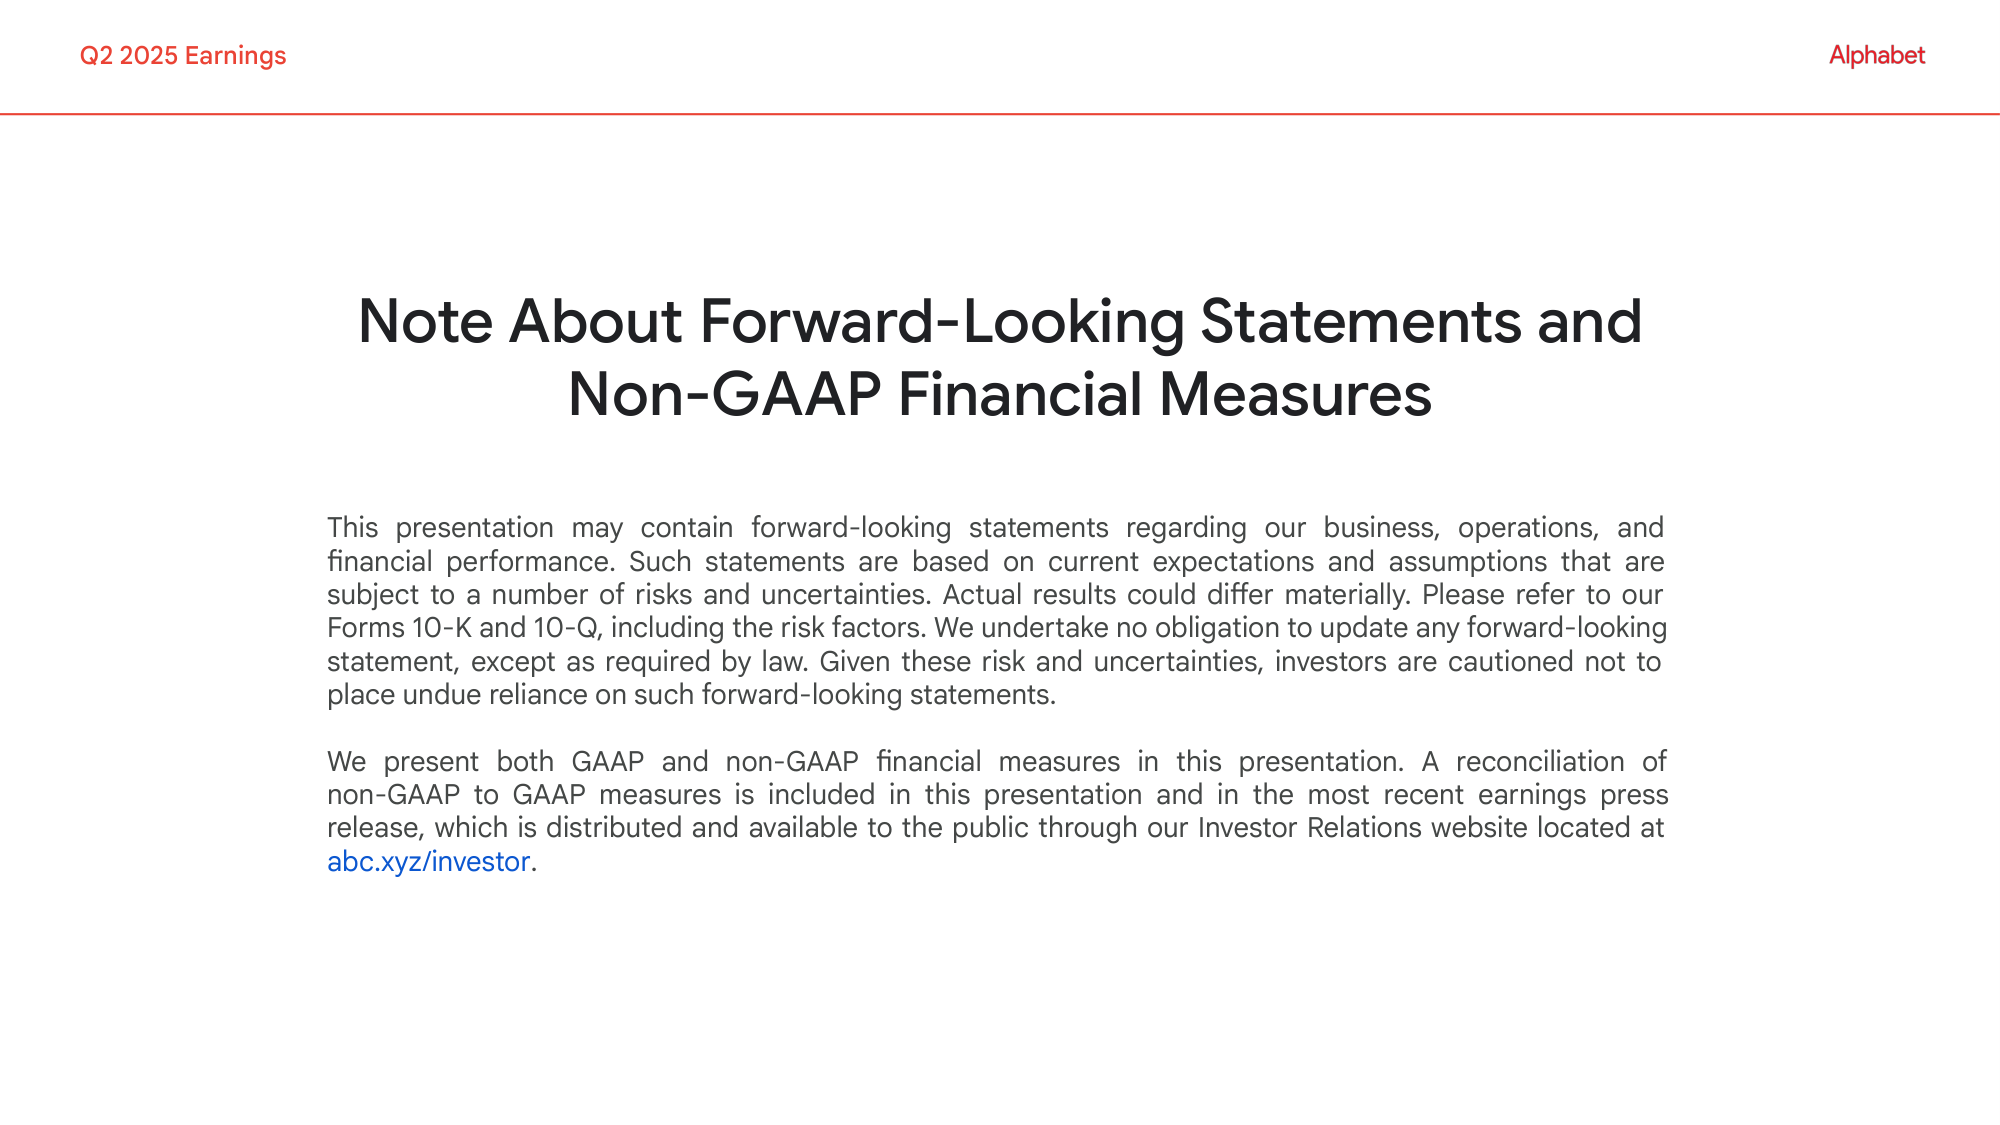


--- Result 5 ---
Caption: Q1 2025 Earnings

Alphabet

Alphabet Capital Expenditures

in Millions, except Percentages; unaudited

$20,000
= $17,197
=
Fa $142
$15,000 $13,186 ae
® d 13,061
5 $12,012 $
2
me}
© $10,000
oO
Qa
<
Ww
S $5,000
Qa
is]
(s)

$0

Q1'24 Q2'24 Q3'24 Q4’24 Q1'25

Y/Y Growth +91% +91% +62% +30% +43%



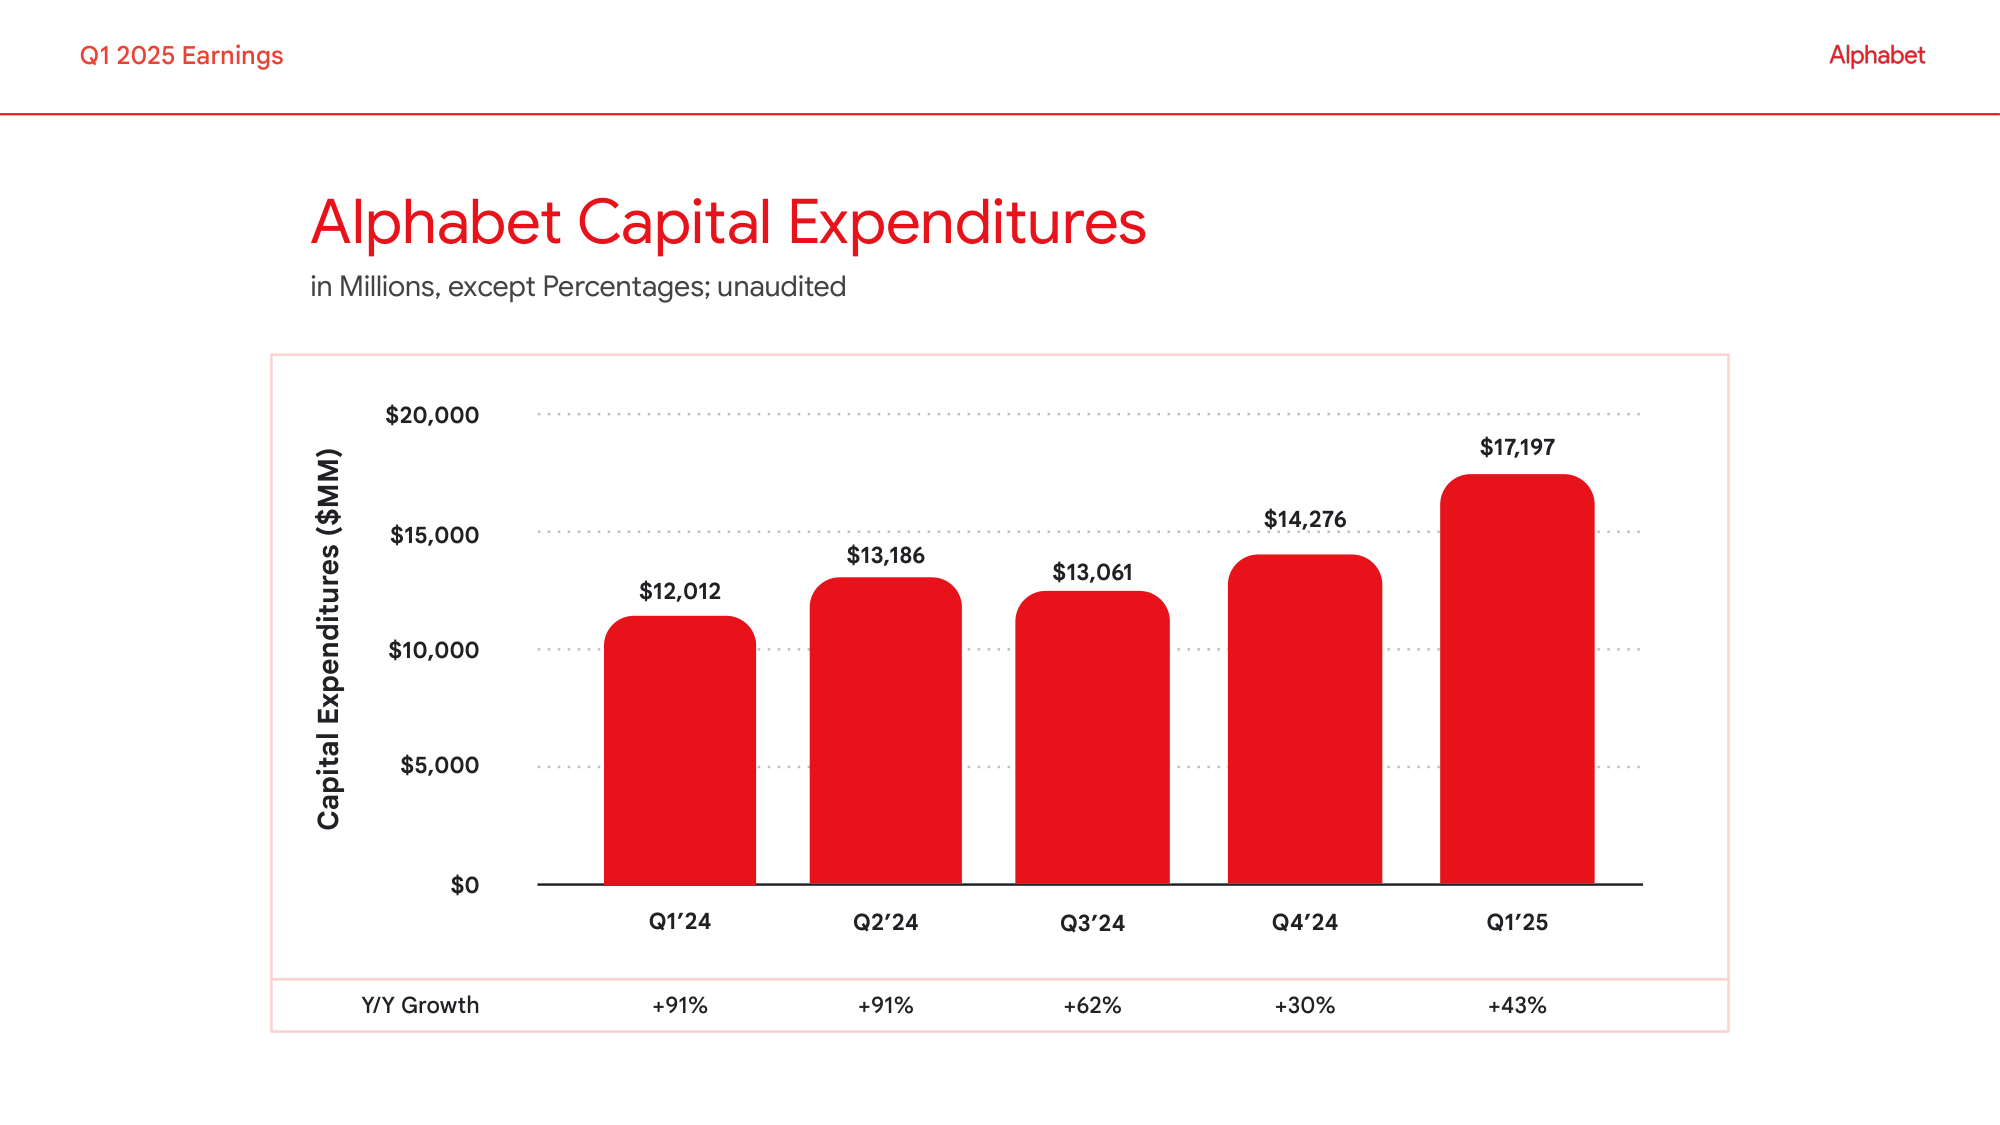

In [15]:
from IPython.display import Image, display
import os

query = "Note"
faiss_retriever = faiss_store.as_retriever(search_kwargs={"k": 5})
results = faiss_retriever.invoke(query)

for i, doc in enumerate(results):
    image_path = doc.metadata["image_path"]
    print(f"\n--- Result {i+1} ---")
    print("Caption:", doc.page_content)
    if os.path.exists(image_path):
        display(Image(filename=image_path))
